In [1]:
#figuring out which GPU to use...
!nvidia-smi

Thu Mar  4 05:56:05 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:1A:00.0 Off |                  N/A |
| 16%   32C    P8     1W / 250W |     11MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:1B:00.0 Off |                  N/A |
| 16%   36C    P8    20W / 250W |     11MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [2]:
import os

#using GPU, comment out if on CPU
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = "5"


In [3]:
%load_ext autoreload
%autoreload 2

from halotools.sim_manager import CachedHaloCatalog
from halotools.empirical_models import PrebuiltHodModelFactory
from halotools.mock_observables.two_point_clustering import tpcf
from halotools.mock_observables import return_xyz_formatted_array

from tensorflow_probability import edward2 as ed

import diffhod

from diffhod.components import Zheng07Cens, Zheng07SatsRelaxedBernoulli, NFWProfile

#from flowpm.utils import cic_paint
import tensorflow as tf

%pylab inline

batch mode...


/home/ben.horowitz/miniconda3/envs/dhod2/lib/python3.8/site-packages/diffhod-0.1-py3.8.egg/diffhod/components.py:8: UserWarning: tfp.edward2 module is deprecated and will be removed on 2019-12-01. Use https://github.com/google/edward2 library instead.


Populating the interactive namespace from numpy and matplotlib


In [4]:
tf.__version__

'2.2.0'

In [5]:
#TF2 compatable painter
def cic_paint(mesh, part, weight=None, name="CiCPaint"):
  """
  Paints particules on a 3D mesh.
  Parameters:
  -----------
  mesh: tensor (batch_size, nc, nc, nc)
    Input 3D mesh tensor
  part: tensor (batch_size, npart, 3)
    List of 3D particle coordinates, assumed to be in mesh units if
    boxsize is None
  weight: tensor (batch_size, npart)
    List of weights  for each particle
  """
  with tf.name_scope(name):
    mesh = tf.convert_to_tensor(mesh, name="mesh")
    part = tf.convert_to_tensor(part, name="part")
    if weight is not None:
      weight = tf.convert_to_tensor(weight, name="weight")

    shape = tf.shape(mesh)
    batch_size, nx, ny, nz = shape[0], shape[1], shape[2], shape[3]
    nc = nz

    # Flatten part if it's not already done
    if len(part.shape) > 3:
      part = tf.reshape(part, (batch_size, -1, 3))

    # Extract the indices of all the mesh points affected by each particles
    part = tf.expand_dims(part, 2)
    floor = tf.floor(part)
    connection = tf.expand_dims(tf.constant([[[0, 0, 0], [1., 0, 0],[0., 1, 0],
                                              [0., 0, 1],[1., 1, 0],[1., 0, 1],
                                              [0., 1, 1],[1., 1, 1]]]), 0)

    neighboor_coords = floor + connection
    kernel = 1. - tf.abs(part - neighboor_coords)
    # Replacing the reduce_prod op by manual multiplication
    # TODO: figure out why reduce_prod was crashing the Hessian computation
    kernel = kernel[..., 0] * kernel[..., 1] * kernel[..., 2]

    if weight is not None: kernel = tf.multiply(tf.expand_dims(weight, axis=-1) , kernel)

    neighboor_coords = tf.cast(neighboor_coords, tf.int32)
    neighboor_coords = tf.math.mod(neighboor_coords , nc)

    # Adding batch dimension to the neighboor coordinates
    batch_idx = tf.range(0, batch_size)
    batch_idx = tf.reshape(batch_idx, (batch_size, 1, 1, 1))
    b = tf.tile(batch_idx, [1] + list(neighboor_coords.get_shape()[1:-1]) + [1])
    neighboor_coords = tf.concat([b, neighboor_coords], axis=-1)

    update = tf.scatter_nd(tf.reshape(neighboor_coords, (-1, 8,4)),tf.reshape(kernel, (-1, 8)),[batch_size, nx, ny, nz])
    mesh = mesh + update
    return mesh


In [6]:
def _initialize_pk(shape,boxsize,kmin,dk):
    """
       Helper function to initialize various (fixed) values for powerspectra... not differentiable!
    """
    I = np.eye(len(shape), dtype='int') * -2 + 1

    W = np.empty(shape, dtype='f4')
    W[...] = 2.0
    W[..., 0] = 1.0
    W[..., -1] = 1.0
    kedges = np.arange(kmin, np.pi * 3 / 2 + dk/2, dk)

    k = [np.fft.fftfreq(N, 1. / (N * 2 * np.pi / L))[:pkshape].reshape(kshape) for N, L, kshape, pkshape in zip(shape.as_list(), boxsize, I, shape.as_list())]
    kmag = sum(ki ** 2 for ki in k) ** 0.5

    xsum = np.zeros(len(kedges) + 1)
    Nsum = np.zeros(len(kedges) + 1)

    dig = np.digitize(kmag.flat, kedges)

    xsum.flat += np.bincount(dig, weights=(W * kmag).flat, minlength=xsum.size)
    Nsum.flat += np.bincount(dig, weights=W.flat, minlength=xsum.size)
    dig = tf.convert_to_tensor(dig,dtype=tf.int32)
    Nsum = tf.convert_to_tensor(Nsum,dtype=tf.complex64)
    xsum = tf.convert_to_tensor(np.array(xsum))
    W = tf.convert_to_tensor(np.array(W))
    k = np.array(k)
    kedges = tf.convert_to_tensor(np.array(kedges))
    return dig, Nsum, xsum, W, k, kedges

In [7]:
#updated pk for batch mode...
#@tf.function
def pk(field,kmin=5,dk=0.8,shape = False,boxsize= False):  
    print("traced!")
    """
    Calculate the powerspectra given real space field
    
    Args:
        
        field: real valued field 
        kmin: minimum k-value for binned powerspectra
        dk: differential in each kbin
        shape: shape of field to calculate field (can be strangely shaped?)
        boxsize: length of each boxlength (can be strangly shaped?)
    
    Returns:
        
        kbins: the central value of the bins for plotting
        power: real valued array of power in each bin
        
    """
     
    bs = field.shape[0] #batch size

    dig, Nsum, xsum, W, k, kedges = _initialize_pk(shape,boxsize,kmin,dk)

    #convert field to complex for fft
    field_complex = tf.dtypes.cast(field,dtype=tf.complex64)

    #fast fourier transform
    fft_image = tf.map_fn(tf.signal.fft3d, field_complex)#, dtype=None, parallel_iterations=None, back_prop=True,
    #swap_memory=False, infer_shape=True, name=None
    #)


    #absolute value of fast fourier transform
    pk = tf.math.real(fft_image*tf.math.conj(fft_image))
    #calculating powerspectra
    Psum = tf.zeros(tf.size(kedges) + 1, dtype=tf.complex64)
    real = tf.reshape(tf.math.real(pk),[bs,-1,])
    imag = tf.reshape(tf.math.imag(pk),[bs,-1,])


    #def bincount func

    def bincount(x):
        return tf.math.bincount(dig, weights=(tf.reshape(W,[-1])  * x), minlength=tf.size(xsum))
    #Psum1 = tf.dtypes.cast(tf.vectorized_map(bincount, imag),dtype=tf.complex64)*1j
    #Psum2 = tf.dtypes.cast(tf.vectorized_map(bincount, real),dtype=tf.complex64)
    Psum1 = tf.dtypes.cast(tf.map_fn(
     bincount, imag, dtype=None, parallel_iterations=None, back_prop=True,
     swap_memory=False, infer_shape=True, name=None
     ),dtype=tf.complex64)*1j

    Psum2 = tf.dtypes.cast(tf.map_fn(
     bincount, real, dtype=None, parallel_iterations=None, back_prop=True,
     swap_memory=False, infer_shape=True, name=None
     ),dtype=tf.complex64)


    power = ((Psum + Psum1+Psum2)/ Nsum)[:,1:-1]* boxsize.prod() 

    #normalization for powerspectra
    norm = tf.dtypes.cast(tf.reduce_prod(shape),dtype=tf.float32)**2

    #find central values of each bin
    kbins = kedges[:-1]+ (kedges[1:] - kedges[:-1])/2

    return kbins,tf.dtypes.cast(power,dtype=tf.float32)/norm

In [8]:
# Load a reference halo catalog
halocat = CachedHaloCatalog(simname = 'bolshoi', redshift=0.) 

# Removing subhalos and convert table to tensors
halo_table = halocat.halo_table
halo_table = halo_table[halo_table['halo_pid'] == -1]
halo_table = halo_table[halo_table['halo_x'] < 128]
halo_table = halo_table[halo_table['halo_y'] < 128]
halo_table = halo_table[halo_table['halo_z'] < 128]

tf_halocat = {k: tf.convert_to_tensor(halo_table[k], dtype=tf.float32) for k in halo_table.colnames}

In [9]:
# We first load our reference halotools model
zheng07_model = PrebuiltHodModelFactory('zheng07', redshift =-0, 
                                        modulate_with_cenocc=True)

In [10]:
# Let's see what are the parameters of the model
zheng07_model.param_dict

{'logMmin': 12.02,
 'sigma_logM': 0.26,
 'logM0': 11.38,
 'logM1': 13.31,
 'alpha': 1.06}

In [11]:
zheng07_model.populate_mock(halocat)

In [12]:
# Here is how we define the same model in diffhod
@tf.function
def hod(halo_cat, logMmin, sigma_logM, logM0, logM1, alpha, max_sat=40, temp=0.01,bs=10):
  ### Occupation model ###
  n_cen = Zheng07Cens(halo_cat['halo_mvir'],
                      sigma_logM=sigma_logM,
                      logMmin=logMmin,
                      temperature=temp)
  n_sat = Zheng07SatsRelaxedBernoulli(halo_cat['halo_mvir'],
                                      n_cen,
                                      logM0=logM0,
                                      logM1=logM1,
                                      alpha=alpha,
                                      sample_shape=(max_sat,),
                                      temperature=temp)
  
  ### Phase Space model ###
  # Centrals are just located at center of halo
  pos_cen = ed.Deterministic(tf.stack([halo_cat['halo_x'],
                                        halo_cat['halo_y'],
                                        halo_cat['halo_z']], axis=-1))

  # Satellites follow an NFW profile centered on halos
  pos_sat = NFWProfile(pos=pos_cen,
                        concentration=halo_cat['halo_nfw_conc'],
                        Rvir=halo_cat['halo_rvir'],
                        sample_shape=(max_sat,))
  
  return {'pos_cen':pos_cen,'n_cen':n_cen, 'pos_sat':pos_sat,  'n_sat':n_sat}

In [13]:
#batch compatable painter
@tf.function
def paint_galaxies(gal_cat, nc=128):
    # Take centrals and rescale them to the boxsize
    
    bs = gal_cat['n_sat'].shape[1]
    
    sample1 = gal_cat['pos_cen'] / 32. * nc
    weights1 = gal_cat['n_cen']
    # Take sats and rescale them to the boxize
  
    sample2 = tf.reshape(gal_cat['pos_sat'], [-1,3]) / 32. * nc
    weights2 = tf.reshape(gal_cat['n_sat'],[bs,-1])
    
    sample1_r = tf.tile(tf.expand_dims(sample1,0),[bs,1,1])
    print(sample1_r.shape,weights1.shape)
    rho1 = cic_paint(tf.zeros((bs, nc, nc, nc)),sample1_r, weights1)
    sample2_r = tf.tile(tf.expand_dims(sample2,0),[bs,1,1])
    print(sample2_r.shape,weights2.shape)

    rho2 = cic_paint(tf.zeros((bs, nc, nc, nc)),sample2_r, weights2)
    rho = rho1+rho2
    return rho

In [14]:
# sampling galaxies from the model, with given params
@tf.function
def sample(halo_cat, logMmin, sigma_logM, logM0, logM1, alpha):
    return paint_galaxies(hod(halo_cat,logMmin, sigma_logM, logM0, logM1, alpha))

In [15]:
#check all variables for batch-ness

rho = sample(tf_halocat, [15.02,11.0,10.02], [0.26,0.22,0.40], [10.0,11.,13.0], [10.31,12.0,13.0], [1.06,1.06,1.06])

Tensor("Pow:0", shape=(3,), dtype=float32)
Instructions for updating:
`AffineScalar` bijector is deprecated; please use `tfb.Shift(loc)(tfb.Scale(...))` instead.
(3, 139905, 3) (3, 139905)
(3, 5596200, 3) (3, 5596200)


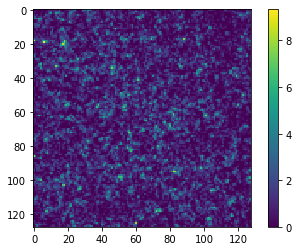

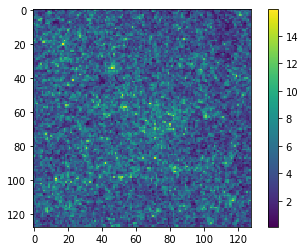

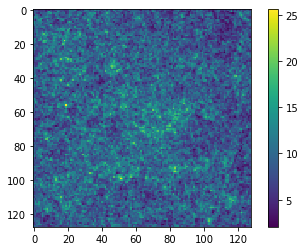

In [16]:

#check that something different is happening :P

imshow(np.array(rho[0]).sum(axis=0))
colorbar()
show()
imshow(np.array(rho[1]).sum(axis=0))
colorbar()
show()

imshow(np.array(rho[2]).sum(axis=0))
colorbar()
show()


In [17]:
#benchmark pk func.. seems to be re-traced a lot? Maybe can be optimized...
%timeit k1, pkr1 = pk(rho, shape=rho[0].shape, boxsize= np.array([64,64,64]), kmin=0.1,dk=.05)


traced!


<ipython-input-6-5ab92cad888c>:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  kmag = sum(ki ** 2 for ki in k) ** 0.5


traced!
traced!
traced!
traced!
traced!
traced!
traced!
166 ms ± 40.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
#fiducial model
rho = sample(tf_halocat, 12.02, 0.26, 11.38, 13.31, 1.06)
k2, pkr2 = pk(rho,
         shape = rho[0].shape, 
         boxsize = np.array([64,64,64]), 
         kmin=0.1,dk=.1)

Tensor("Pow:0", shape=(), dtype=float32)
(1, 139905, 3) (1, 139905)
(1, 5596200, 3) (1, 5596200)
traced!


<ipython-input-6-5ab92cad888c>:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  kmag = sum(ki ** 2 for ki in k) ** 0.5


In [19]:
pkr2[0]

<tf.Tensor: shape=(46,), dtype=float32, numpy=
array([0.00762647, 0.00285442, 0.00218315, 0.00192633, 0.00151649,
       0.00120916, 0.00132163, 0.00125666, 0.00116455, 0.00109081,
       0.00107207, 0.00098006, 0.00092215, 0.00088998, 0.00087635,
       0.00080182, 0.00080143, 0.00075468, 0.00075376, 0.00073269,
       0.00068673, 0.00067859, 0.00065667, 0.00063216, 0.00062711,
       0.00060467, 0.00057517, 0.00055992, 0.00054526, 0.00053286,
       0.00050984, 0.0004911 , 0.00046729, 0.0004521 , 0.00043592,
       0.00042849, 0.00041316, 0.00040004, 0.00038398, 0.00036844,
       0.00035292, 0.00034755, 0.00032695, 0.0003185 , 0.0003067 ,
       0.00029481], dtype=float32)>

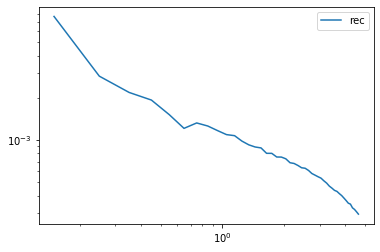

In [20]:
#loglog(k1,pkr1[0], label='data')
loglog(k2,pkr2[0], label='rec')
legend()

In [21]:
pkr2[0]

<tf.Tensor: shape=(46,), dtype=float32, numpy=
array([0.00762647, 0.00285442, 0.00218315, 0.00192633, 0.00151649,
       0.00120916, 0.00132163, 0.00125666, 0.00116455, 0.00109081,
       0.00107207, 0.00098006, 0.00092215, 0.00088998, 0.00087635,
       0.00080182, 0.00080143, 0.00075468, 0.00075376, 0.00073269,
       0.00068673, 0.00067859, 0.00065667, 0.00063216, 0.00062711,
       0.00060467, 0.00057517, 0.00055992, 0.00054526, 0.00053286,
       0.00050984, 0.0004911 , 0.00046729, 0.0004521 , 0.00043592,
       0.00042849, 0.00041316, 0.00040004, 0.00038398, 0.00036844,
       0.00035292, 0.00034755, 0.00032695, 0.0003185 , 0.0003067 ,
       0.00029481], dtype=float32)>

In [22]:
# Let's just compute a diagonal cov (takes a while...)

bs = 10
@tf.function
def get_pk(halocat):
    k2, pkr = pk(sample(tf_halocat, 12.02*np.ones(bs,dtype=float32), 0.26*np.ones(bs,dtype=float32), 11.38*np.ones(bs,dtype=float32), 13.31*np.ones(bs,dtype=float32), 1.06*np.ones(bs,dtype=float32) ),
         shape=rho[0].shape, 
         boxsize= np.array([64,64,64]), 
         kmin=0.1,dk=.1)
    print(pkr.shape)
    return pkr
import time

start_time = time.time()
samps = [get_pk(halocat) for i in range(10)]
end_time = time.time()- start_time
print(end_time)

Tensor("Pow:0", shape=(10,), dtype=float32)
(10, 139905, 3) (10, 139905)
(10, 5596200, 3) (10, 5596200)
traced!
(10, 46)
42.3618905544281


In [23]:
samps = np.stack(samps, axis=0).reshape(100,-1)
diag_std = samps.std(axis=0)
diag_std.shape

(46,)

In [24]:
covar = np.cov(samps.T,bias=False)

In [25]:
inv_covar = np.linalg.inv(covar)#/1000 
#Not currently using full covariance... is worse for some reason...

In [26]:
# Ok sweet, so now we can define these as a function of variables
logM = tf.Variable(12.5)
sig_logM = tf.Variable(0.5)
logM0 = tf.Variable(10.38)
logM1 = tf.Variable(13.01)
alpha = tf.Variable(1.6)

In [27]:
#quick example showing large sample... use this for covariance estimation? might be just as slow with the map_fn

k, pko = pk(sample(tf_halocat, tf.Variable(np.ones(10)*logM,dtype=float32), tf.Variable(sig_logM,dtype=float32), tf.Variable(logM0,dtype=float32), tf.Variable(logM1,dtype=float32), tf.Variable(alpha,dtype=float32)),shape=rho[0].shape, 
     boxsize= np.array([64,64,64]), # WARNING: That's not the right size
     kmin=0.1,dk=.1)



Tensor("Pow:0", shape=(), dtype=float32)
traced!


<ipython-input-6-5ab92cad888c>:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  kmag = sum(ki ** 2 for ki in k) ** 0.5


In [28]:
mean_val = np.mean(np.array(pko),axis=0)
std_val = np.std(np.array(pko),axis=0)

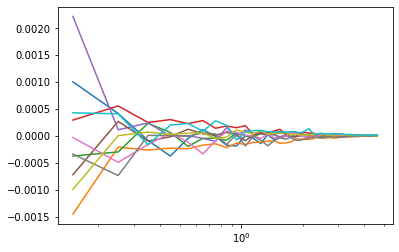

In [29]:
for pki in np.array(pko):
    plt.semilogx(k,(pki-mean_val))

In [30]:
mean_val,std_val 

(array([0.0175375 , 0.01114928, 0.01183448, 0.0086102 , 0.00881696,
        0.00737433, 0.0071944 , 0.00772957, 0.00652468, 0.00592973,
        0.00573651, 0.00499177, 0.00462544, 0.00416799, 0.00390283,
        0.00333144, 0.00329957, 0.00293782, 0.0027022 , 0.00255544,
        0.00236179, 0.00207294, 0.00192658, 0.00175947, 0.00168727,
        0.00150798, 0.00140848, 0.00132337, 0.00122604, 0.00112351,
        0.00105356, 0.00098836, 0.00091444, 0.00084261, 0.00082579,
        0.00077336, 0.00071991, 0.00068532, 0.00064496, 0.00060527,
        0.00057766, 0.00054502, 0.00051228, 0.0004835 , 0.0004545 ,
        0.00043951], dtype=float32),
 array([1.00265560e-03, 4.06226987e-04, 1.78179631e-04, 1.81890151e-04,
        1.52868161e-04, 1.59408286e-04, 1.19838733e-04, 1.47465951e-04,
        1.00858808e-04, 1.12483816e-04, 5.48301759e-05, 8.75553815e-05,
        7.64917568e-05, 6.58938006e-05, 7.14451162e-05, 5.74288861e-05,
        5.22453483e-05, 4.83921940e-05, 4.04754282e-05, 4.42042

In [31]:
def batch_func(x,avg_samp=1):
    #for each set of parameters, we average over avg_samp runs
        _, pkr = pk(sample(tf_halocat, np.ones(avg_samp,dtype=np.float32)*x[0], np.ones(avg_samp,dtype=np.float32)*x[1], np.ones(avg_samp,dtype=np.float32)*x[2], np.ones(avg_samp,dtype=np.float32)*x[3], np.ones(avg_samp,dtype=np.float32)*x[4]),#sample(tf_halocat, X[:,0], X[:,1], 11.38, X[:,2], X[:,3]),
                 shape=rho[0].shape, 
                 boxsize= np.array([64,64,64]), # WARNING: That's not the right size
                 kmin=0.1,dk=.1)
        return tf.reduce_mean(pkr,axis=0)

In [32]:
output = batch_func(np.array([12.0,1.01,10.38,13.01, 0.20],dtype=np.float32))

Tensor("Pow:0", shape=(1,), dtype=float32)
traced!


<ipython-input-6-5ab92cad888c>:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  kmag = sum(ki ** 2 for ki in k) ** 0.5


In [33]:
pkr2

<tf.Tensor: shape=(1, 46), dtype=float32, numpy=
array([[0.00762647, 0.00285442, 0.00218315, 0.00192633, 0.00151649,
        0.00120916, 0.00132163, 0.00125666, 0.00116455, 0.00109081,
        0.00107207, 0.00098006, 0.00092215, 0.00088998, 0.00087635,
        0.00080182, 0.00080143, 0.00075468, 0.00075376, 0.00073269,
        0.00068673, 0.00067859, 0.00065667, 0.00063216, 0.00062711,
        0.00060467, 0.00057517, 0.00055992, 0.00054526, 0.00053286,
        0.00050984, 0.0004911 , 0.00046729, 0.0004521 , 0.00043592,
        0.00042849, 0.00041316, 0.00040004, 0.00038398, 0.00036844,
        0.00035292, 0.00034755, 0.00032695, 0.0003185 , 0.0003067 ,
        0.00029481]], dtype=float32)>

In [34]:
@tf.function
def loss(X):
    pkr = tf.map_fn(batch_func,X)
    return tf.reduce_sum(-1/46*((pkr - pkr2)/std_val)**2,axis=1)
   # return tf.reduce_sum(-1*(pkr - pkr2) @ (inv_covar) @ tf.transpose(pkr - pkr2),axis=1)


In [35]:
#checking loss function
X_test = tf.Variable(np.array([[12.02, 0.26, 10.38, 13.31, 1.06],[13.02, 0.26, 10.38, 13.31, 1.06]],dtype=float32),dtype=float32)

output = loss(X_test)

print(output)

traced!


<ipython-input-6-5ab92cad888c>:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  kmag = sum(ki ** 2 for ki in k) ** 0.5


tf.Tensor([  -0.53670645 -502.59515   ], shape=(2,), dtype=float32)


In [49]:
import numpy as np
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp
tf.enable_v2_behavior()

num_burnin_steps = int(3e1) #oops....
num_chains = 5


adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=loss,
        num_leapfrog_steps=3,
        step_size=.03), #can play a lot with this number...
    num_adaptation_steps=int(num_burnin_steps * 0.8))


In [50]:
#start spread out around some point
var = (np.random.random([num_chains, 5])-0.5)*np.array([0.1,0.02,0.01,0.1,0.01])*0.010

In [51]:

num_results = 100

# Initial state of the chain
init_state = tf.Variable(np.ones([num_chains, 5], dtype=dtype)*np.array([12.12, 0.36, 10.36, 13.21, 1.16],dtype=float32)+var,dtype=float32)

@tf.function
def run_chain():
  # Run the chain (with burn-in).
    samples, is_accepted = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=init_state,
      kernel=adaptive_hmc,
      trace_fn=lambda _, pkr: pkr.inner_results.is_accepted)

    return samples,is_accepted#sample_mean, sample_stddev, is_accepted


In [52]:
import time
current_time = time.time()
q,is_accepted = run_chain()
run_time = time.time()-current_time
print(run_time)

1351.1809055805206


In [53]:
#time in hours, since math is hard
print(run_time/60/60)

0.37532802932792236


In [54]:
#make sure chain moved...
q[0]-q[-1]



<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[ 0.03108692,  0.02114519,  0.32091618, -0.04326057, -0.04916441],
       [ 0.23556232,  0.16214383, -0.16865921, -0.3617754 , -0.16461825],
       [ 0.16882324,  0.3029456 , -0.07311249, -0.14530945, -0.16788352],
       [ 0.25316143,  0.32675102,  0.06105042, -0.39542675,  0.04511976],
       [ 0.06106663,  0.24664219, -0.16117096, -0.02680969, -0.00187683]],
      dtype=float32)>

In [ ]:
loss(q[0])

In [ ]:
plt.hist(np.array(q).reshape(-1,5)[:,0])

In [215]:
import corner

In [216]:
q.shape

TensorShape([2000, 5, 5])

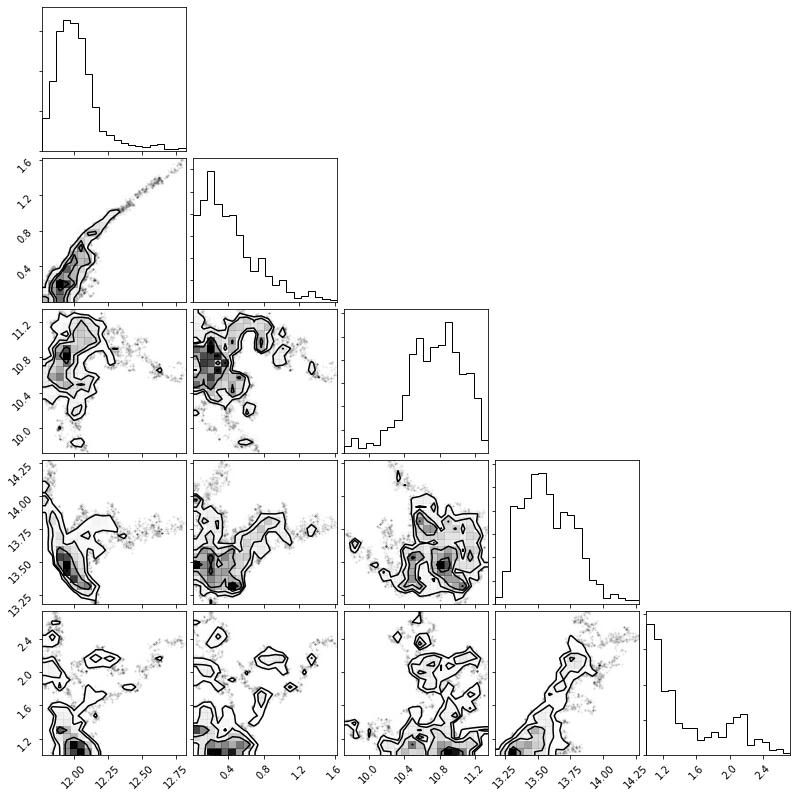

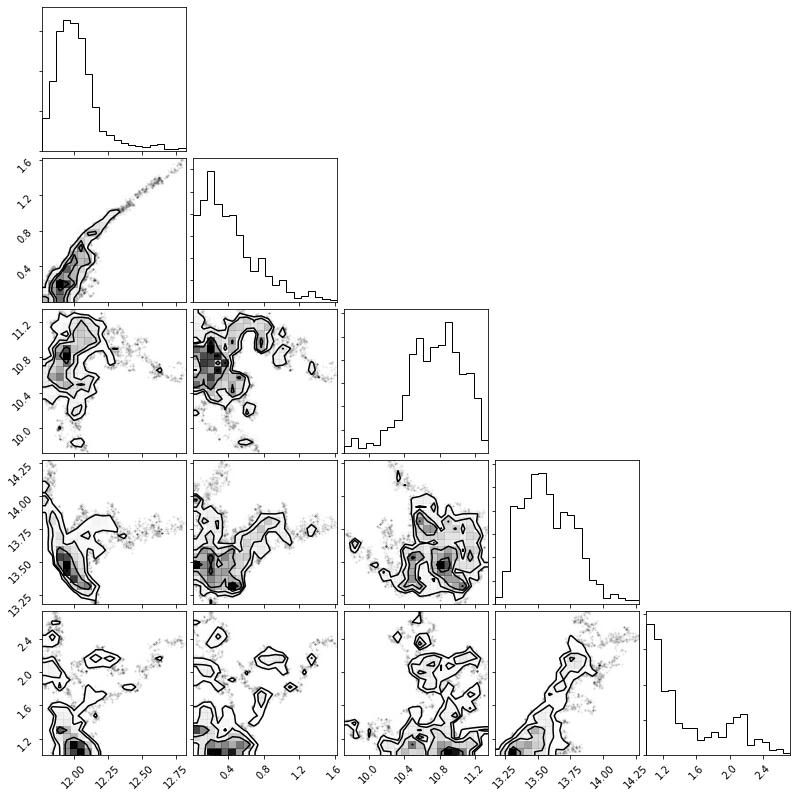

In [217]:
corner.corner(np.array(q[:,:,:]).reshape(-1,5)[:],smooth=0.300)

In [173]:
q.shape

TensorShape([10000, 5, 5])

In [50]:
#logMmin, sigma_logM, logM1, alpha

In [218]:
q[:,[0,1,5],:].shape

TypeError: Only integers, slices (`:`), ellipsis (`...`), tf.newaxis (`None`) and scalar tf.int32/tf.int64 tensors are valid indices, got [0, 1, 5]

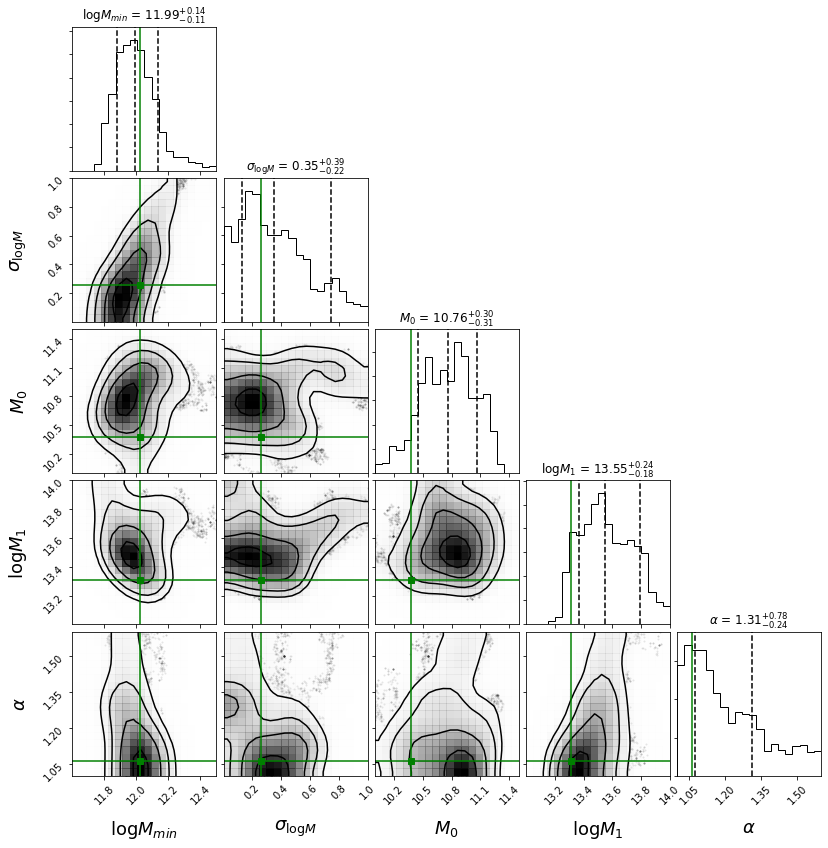

In [224]:
value1 = [12.02, 0.26, 10.38,13.31, 1.06]
#range=[(11.5,12.4),(0.00,0.60),(13.1,14.1),(0.950,1.3)]
levels = 1.0 - np.exp(-0.5 * np.arange(0.5, 2.1, 0.5) ** 2)
figure = corner.corner(np.array(q)[:,:].reshape(-1,5),labels = [r"$\log M_{min}$", r"$\sigma_{\log M}$", r"$M_0$",r"$\log M_1$", r"$\alpha$"],label_kwargs={"fontsize":18} ,
                       quantiles=[0.16, 0.5, 0.84],levels=levels,show_titles=True,
                       smooth=2.0,plot_datapoints=True,range=[[11.6,12.5],[0.0,1.0],[10,11.5],[13,14],[1.0,1.6]])
ndim = 5
# Extract the axes
axes = np.array(figure.axes).reshape((ndim, ndim))

# Loop over the diagonal
for i in range(ndim):
    ax = axes[i, i]
    ax.axvline(value1[i], color="g")

# Loop over the histograms
for yi in range(ndim):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.axvline(value1[xi], color="g")
        ax.axhline(value1[yi], color="g")
        ax.plot(value1[xi], value1[yi], "sg")
plt.savefig("HMC_Output.pdf")

In [282]:
#np.save("HMC_output_020321",q[:])

In [284]:
#could run for longer and probably get better curves...